# [LAB 10] 9.일원분산분석 (2)

### 분산 분석 패키지 비교
| 항목                            | SciPy                         | Statsmodels                                  | Pingouin                                             |
| ----------------------------- | ----------------------------- | -------------------------------------------- | ---------------------------------------------------- |
| **ANOVA 종류 지원**               | One-way ANOVA, Welch ANOVA 기본 | One-way ANOVA를 공식 테이블 형태로 제공 (공식 ANOVA 테이블)  | One-way ANOVA, Welch ANOVA 지원                        |
| **사후검정(Post-hoc)**            | 없음                            | Tukey HSD 제공 (`pairwise_tukeyhsd`)           | Tukey HSD, Games–Howell, Bonferroni 등 사후검정 **최대 지원** |
| **등분산성 위반 시 처리(Welch)**       | Welch ANOVA 제공                | `anova_lm(..., robust='hc3')` 등 이분산 보정 옵션 제공 | `welch_anova` 함수 제공                                  |
| **비모수 대안(Kruskal, Friedman)** | Kruskal, Mann-Whitney 있음      | 있음                                           | Kruskal, Friedman 지원                                 |
| **결과 표의 가독성**                 | 낮음(수치만 제공)                    | 좋음(SS, MS, df, F 등을 담은 표 형식)                 | 매우 좋음(효과크기·CI·사후검정 결과 등 실무 중심 표 제공)                  |


> 추천 프로세스
Pingouin 으로 일원분산분석을 수행하되 등분산성이 위배되면 welch _ anova 로 전환

### #01.준비작업
#### [1] 패키지 참조

In [1]:
from hossam import load_data
from pandas import DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# ------------------------------
# 분산분석을 위한 라이브러리
# ------------------------------
from pingouin import anova
from pingouin import welch_anova

# ------------------------------
# 사후검정을 위한 라이브러리
# ------------------------------
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell


In [9]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

#### [2] 그래프 초기화
식당 고객의 결제 금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등 기본 정보를 담은 데이터이다. 금/토/일 팁 평균에 차이가 있는지 검정하라

In [2]:
origin = load_data('tips')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head()


[data] https://data.hossam.kr/data/kaggle/tips.xlsx
[desc] 식당 고객의 결제 금액, 팁, 성별, 흡연 여부, 요일, 시간대, 일행 규모 등 기본 정보를 담은 데이터 분석·시각화 실습용 샘플 데이터 (출처: https://www.kaggle.com/datasets/sakshisatre/tips-dataset)

field       description
----------  -------------
total_bill  총 결제 금액
tip         팁 금액
sex         성별
smoker      흡연 여부
day         방문 요일
time        방문 시간대
size        일행 규모


===== 데이터 크기 확인 =====
데이터셋 크기: (244, 7)
열 개수: 7
행 개수: 244

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB
None


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


#### [4] 데이터 전처리 - 금/토/일 데이터만 추출

In [6]:
df = origin[(origin['day'] == 'Fri') | (origin['day'] == 'Sat') | (origin['day'] == 'Sun')]
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### #02. 데이터 분포 및 가정 확인
#### [1] 데이터 분포
요일별 팁 분포를 박스플롯과 산점으로 확인한다



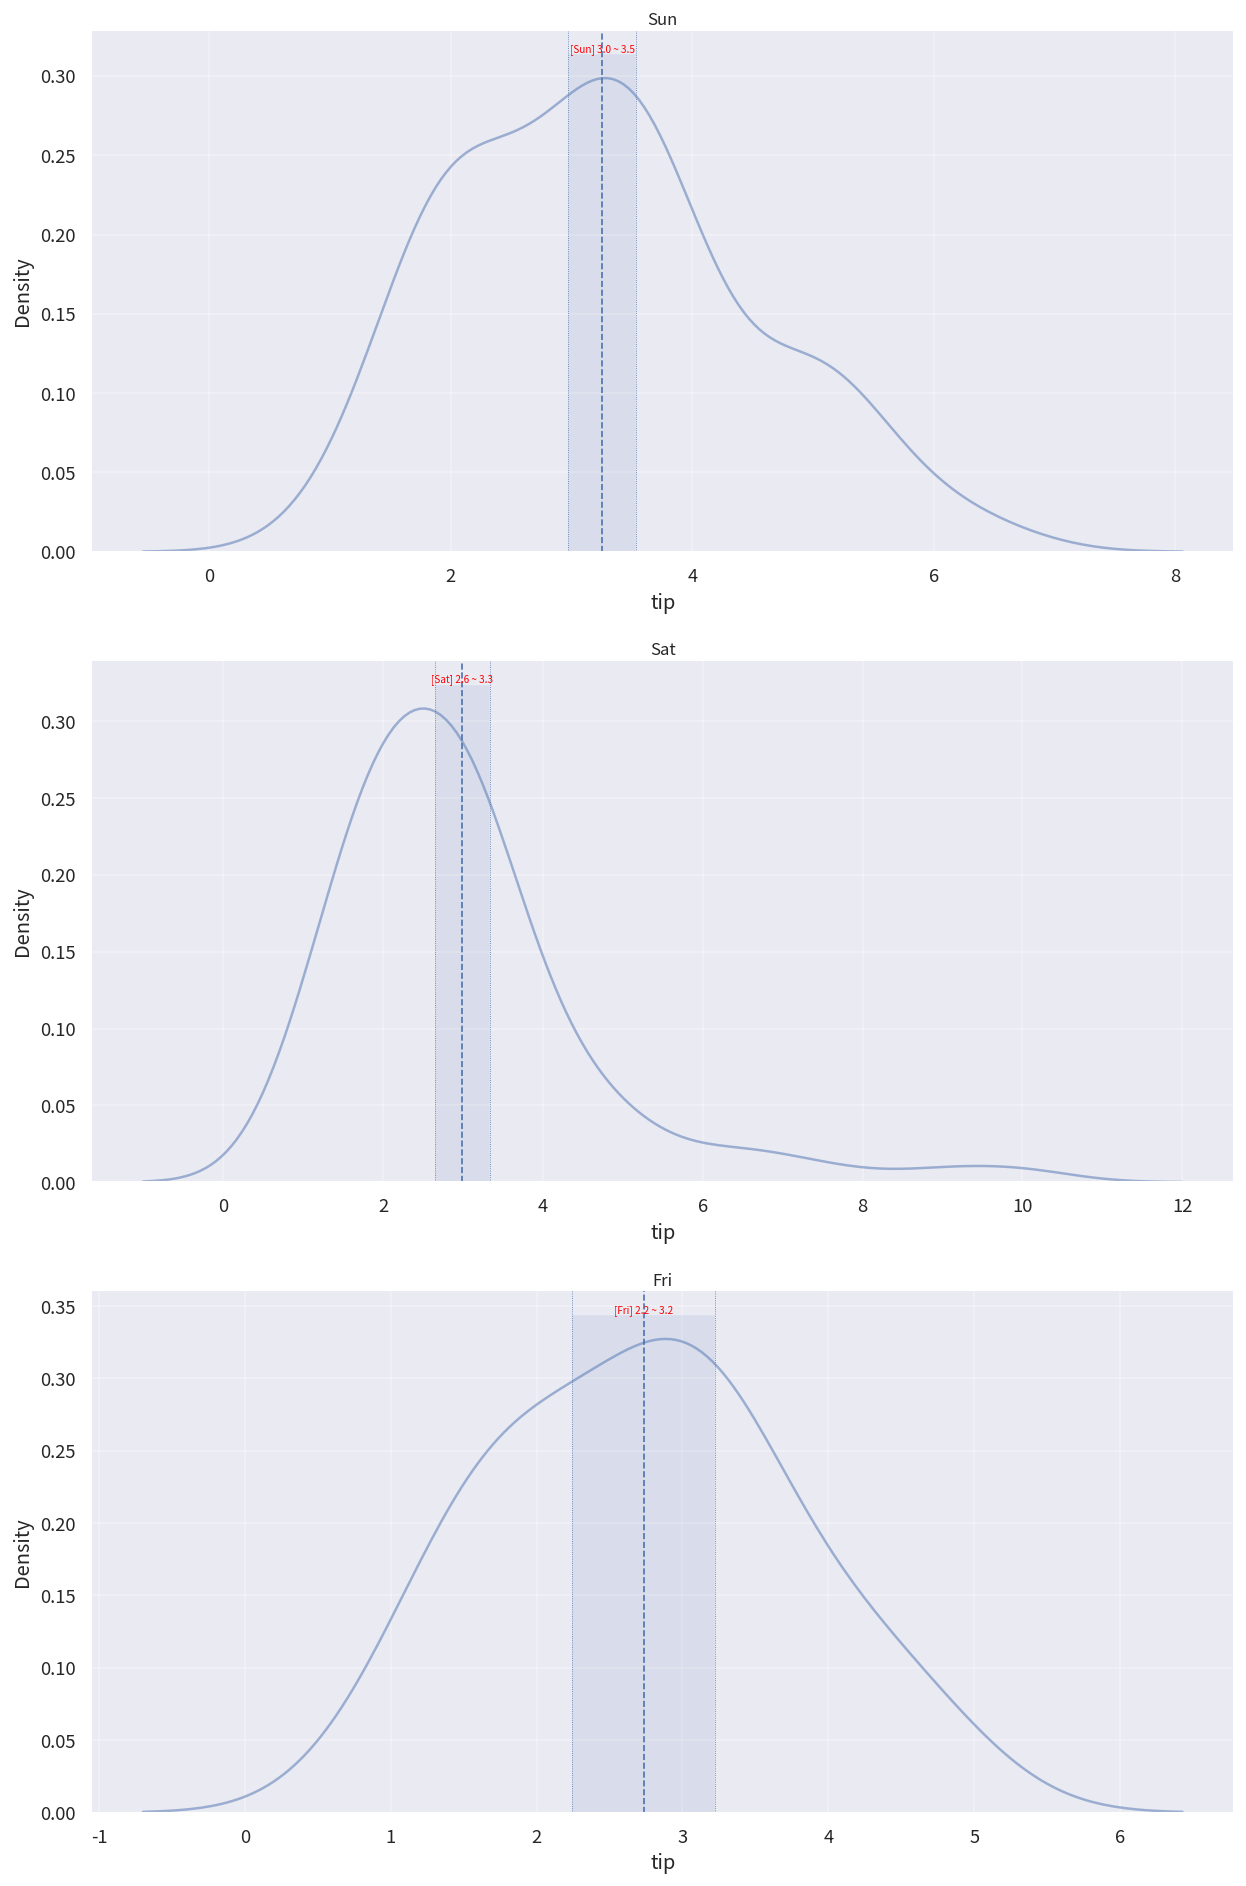

In [10]:
# 확인할 데이터 필드
field = 'tip'

# 집단을 구분하는 필드(hue)
hue_field = 'day'

# 요일 종류 구하기
hue_values = df[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화
width_px  = 1280      # 그래프 가로 크기
height_px = 640 * 3   # 그래프 세로 크기
rows = 3              # 그래프 행 수
cols = 1              # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

for i, v in enumerate(hue_values):

    temp = df[df[hue_field] == v]
    #display(temp)

    # KDE Plot 그리기
    sb.kdeplot(data=temp, x=field, fill=False, alpha=0.5, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간
    max = temp[field].max()               # 최대값
    clevel = 0.95                         # 신뢰수준
    dof = len(temp[field]) - 1            # 자유도
    sp_mean = temp[field].mean()          # 표본평균
    sp_std = temp[field].std(ddof=1)      # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field]))   # 표본표준오차

    cmin, cmax = t.interval(
        clevel, dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
    ax[i].axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between(
        (cmin, cmax), 0, ymax, alpha=0.1
    )
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기
    ax[i].text(
        x=(cmax - cmin)/2 + cmin,
        y=ymax,
        s=f"[{v}] {cmin:.1f} ~ {cmax:.1f}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 4) 출력
plt.tight_layout()     # 여백 제거
plt.show()             # 그래프 화면 출력
plt.close()            # 그래프 작업 종료


<인사이트>
1. 모든 요일에서 KDE 는 완만한 종 모양이며, 오른쪽 꼬리가 약간 긴 형태를 보인다
2. 요일별 평균은 KDE 의 최고점보다 약간 오른쪽에 있으며, SUN > SAT > FRI 순으로 높게 나타난다
   - 평균 팁은 일요일이 가장 높고 금요일이 가장 낮다
3. 신뢰구간의 폭 : 주말은 팁 금액 변화가 크고, 금요일은 비교적 안정적으로 낮은 팁이 발생한다
   - sun 과 sat 은 폭이 더 넓음 > 팁 변동성이 크다
   - FRI 는 폭이 좁음 > 팁 금액이 비교적 일정하다

#### [2] 정규성, 등분산성 검정

In [11]:
# 요일별 그룹 생성
groups = [(name, grp['tip']) for name, grp in df.groupby('day')]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "field": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok


# 등분산성 검정 선택
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups])
else:
    test_name = "Levene"
    stat, p = levene(*[s.values for _, s in groups], center='median')

equal_var = p > 0.05

report.append({
    "field": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('field')
report_df


,statistic,p-value,result
field,,,
Fri,0.416676,8.119325e-01,True
Sat,49.144308,2.130341e-11,False
Sun,3.396232,1.830280e-01,True
Levene,0.651391,5.225516e-01,True


정규성 위배가 ANOVA 불가를 의미하는 것은 아니다
ANOVA는 정규성에 비교적 강건(robust)하다.
특히 그룹 수가 3개 이상이고, 각 그룹 표본 수가 적당히 크면(일반적으로 n ≥ 30) → 정규성 위배가 있어도 ANOVA 결과는 크게 흔들리지 않는다.
따라서 집단이 비정규라도 표본수가 크면 ANOVA 그대로 진행해도 OK.

### #03. 일원분산분석 수행
| 구분        | 수식                         | 내용                      |
|-------------|------------------------------|---------------------------|
| 그룹1의 평균 | μ(Fri)                      |                           |
| 그룹2의 평균 | μ(Sat)                      |                           |
| 그룹3의 평균 | μ(Sun)                      |                           |
| 귀무가설(H₀) | μ(Fri) = μ(Sat) = μ(Sun)     | 요일별 팁 평균은 동일하다 |
| 대립가설(H₁) | 위 등식이 성립하지 않는다     | 요일별 팁 평균은 적어도 하나가 다르다 |


#### [1] 분석에 필요한 데이터만 추출


In [13]:
#long-form 데이터
anova_df = origin[['tip', 'day']].copy()
anova_df

,tip,day
0,1.01,Sun
1,1.66,Sun
2,3.50,Sun
3,3.31,Sun
4,3.61,Sun
...,...,...
239,5.92,Sat
240,2.00,Sat
241,2.00,Sat
242,1.75,Sat


#### [2] pingouin 패키지 사용 (추천 방법)

In [14]:
if equal_var :
  pg_anova = anova (data = anova_df , dv='tip',between ='day')

else :
  pg_anova = welch_anova(data = anova_df , dv = 'tip' , between ='day')

pg_anova

,Source,ddof1,ddof2,F,p-unc,np2
0,day,3,240,1.672355,0.173589,0.020476


In [19]:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val <= 0.05 else "귀무")

'statistic: 1.672, p-value: 0.174, 귀무가설 채택'

<인사이트>
세 요일 (fri, sat, sun) 간 평균 팁 금액의 차이를 검정한 결과,유의수준 0.05 기준에서 통계적으로 유의한 차이는 확인되지 않았다 (p=0.174) 요일이 팁 금액 차이에 유의한 영향을 주지 않는 것으로 판단된다

### #05.사후검정 (post hoc)
등분산성이 충족되면 Tukey HSD, 위배되면 Games -howell 을 사용한다



In [18]:
if equal_var:
    print ('=== Tukey HSD ===')
    hoc_df = pairwise_tukey(data=anova_df, dv='tip', between='day')

else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(anova_df, dv='tip', between='day')
hoc_df


=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Fri,Sat,2.734737,2.993103,-0.258367,0.348935,-0.740444,0.880645,-0.166274
1,Fri,Sun,2.734737,3.255132,-0.520395,0.353432,-1.472405,0.455805,-0.431509
2,Fri,Thur,2.734737,2.771452,-0.036715,0.361324,-0.101612,0.999623,-0.030468
3,Sat,Sun,2.993103,3.255132,-0.262028,0.216349,-1.211136,0.620382,-0.178644
4,Sat,Thur,2.993103,2.771452,0.221652,0.229016,0.967846,0.767858,0.148857
5,Sun,Thur,3.255132,2.771452,0.483680,0.235811,2.051132,0.172421,0.388762


<인사이트>
- 모든 요일 쌍에서 p-tukey > 0.05 로 나타나 Fri, Sat, Sun 간의 평균 팁 금액의 유의한 차이는 발견되지 않았다
- Fri 와 Sat ,Fri 와 Sun, Sat 과 Sun 비교에서 평균 차이가 존재하더라도 통계적으로 유의하지 않았으며, 이는 표본 내 자연스러운 변동 범위로 볼 수 있다
- Sat 과 Sun 비교에서도 Sat 이 약간 낮은 경향이 있으나 (diff = -0.26) p = 0.620 으로 차이가 유의하지 않다
- Sun 과 Thur 비교는 diff = 0.48 로 가장 큰 평균 차이가 있었지만 p=0.172 통계적 기준을 충족하지 못해 유의한 차이라고 볼 수 없다